# Detecting COVID-19 with Chest X-Rays

Classify Chest X-rays into 3 classes: Normal, Viral Pneumonia, COVID-19

Used The COVID-19 Radiography Dataset on Kaggle: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

In [65]:
%matplotlib inline

import os
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.0


In [66]:
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

# Sort Files into Training and Testing

In [67]:
class_names = ["normal", "viral", "covid"]
root = "COVID-19 Radiography Database"
source_names = ["NORMAL", "COVID-19", "Viral Pneumonia"]

if os.path.isdir(os.path.join(root, 'train', source_names[1])):
    os.mkdir(os.path.join(root, 'test'))
    
    for i, d in enumerate(source_names):
        os.rename(os.path.join(root, d), os.path.join(root, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root, 'test', c))
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root, c)) if x.lower().endswith('png')]
        print(len(images))
        select = random.sample(images, 30)
        for image in select:
            source = os.path.join(root, c, image)
            target = os.path.join(root, 'test', c, image)
            shutil.move(source, target)
            

# Create Dataset Class

In [68]:
"""
class ChestXRayDataset(torch.utils.data.DataLoader):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'{len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_name = ["normal", "viral", "covid"]
        for c in self.class_name:
            self.images[c] = get_images(c)
            
        self.transform = transform
    
    def __len__(self):
        return sum([len(self.images[x]) for x in self.images])
    
    def __getitem__(self, index):
        c_n = random.choice(self.class_name)
        index = index % len(self.images[c_n])
        image_name = self.images[c_n][index]
        image_path = os.path.join(self.image_dirs[c_n], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)
"""
        

'\nclass ChestXRayDataset(torch.utils.data.DataLoader):\n    def __init__(self, image_dirs, transform):\n        def get_images(class_name):\n            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith(\'png\')]\n            print(f\'{len(images)} {class_name} examples\')\n            return images\n        self.images = {}\n        self.class_name = ["normal", "viral", "covid"]\n        for c in self.class_name:\n            self.images[c] = get_images(c)\n            \n        self.transform = transform\n    \n    def __len__(self):\n        return sum([len(self.images[x]) for x in self.images])\n    \n    def __getitem__(self, index):\n        c_n = random.choice(self.class_name)\n        index = index % len(self.images[c_n])\n        image_name = self.images[c_n][index]\n        image_path = os.path.join(self.image_dirs[c_n], image_name)\n        image = Image.open(image_path).convert(\'RGB\')\n        return self.transform(image), self.class_names.ind

# Transform Dataset

In [69]:
root = '../COVID-19/COVID-19 Radiography Database/'

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])     

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])
train_dset = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_dset = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

# Prepare Dataloader

In [70]:
class_names = train_dset.classes
class_names

['covid', 'normal', 'viral']

In [71]:
trainloader = DataLoader(train_dset, batch_size=6, shuffle=True)
testloader = DataLoader(test_dset, batch_size=6, shuffle=False)

print(f'Num training batches: {len(trainloader)}')
print(f'Num testing batches: {len(testloader)}')

Num training batches: 624
Num testing batches: 15


In [72]:
len(train_dset)

3739

In [73]:
len(test_dset)

90

# Visualize Images

In [74]:
for images, labels in trainloader:
    break

[2 1 0 1 1 0]


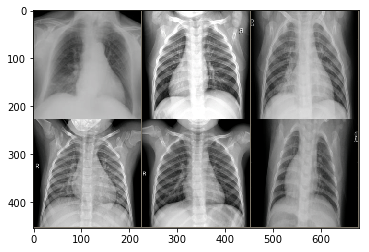

In [75]:
im = make_grid(images, nrow=3)

inv_norm = transforms.Compose([
    transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         [1/0.229, 1/0.224, 1/0.225])
])
new_im = inv_norm(im)
print(labels.numpy())
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(new_im.numpy(), (1, 2, 0)))

In [76]:
ResNetmodel = models.resnet18(pretrained=True)

In [77]:
ResNetmodel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
for param in ResNetmodel.parameters():
    param.requires_grad = False

In [79]:
ResNetmodel.fc = nn.Sequential(nn.Linear(512, 64), nn.ReLU(inplace=True), nn.Dropout(0.5), nn.Linear(64, 3), nn.LogSoftmax(dim=1))

In [80]:
ResNetmodel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNetmodel.fc.parameters(), lr=0.001)

In [82]:
import time

start_time = time.time()

trn_btch_lmt = 800
tst_btch_lmt = 300

epochs = 15

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(trainloader):
        
        if b == trn_btch_lmt:
            break
        
        y_pred = ResNetmodel(X_train)
        
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        loss = criterion(y_pred, y_train)
        
        if (b+1)%200 == 0:
            print(f'EPOCH: {i}   LOSS: {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        
        for b, (X_test, y_test) in enumerate(testloader):
            if b == tst_btch_lmt:
                break

            y_pred = ResNetmodel(X_test)
            
            predicted = torch.max(y_pred, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
        loss = criterion(y_pred, y_test)
        test_losses.append(loss.item())
        test_correct.append(tst_corr)
        
        
print(f'training took {(time.time() - start_time)/60} minutes')

EPOCH: 0   LOSS: 0.45107147097587585
EPOCH: 0   LOSS: 0.19235511124134064
EPOCH: 0   LOSS: 0.40965256094932556
EPOCH: 1   LOSS: 1.2097163200378418
EPOCH: 1   LOSS: 0.4378625154495239
EPOCH: 1   LOSS: 0.5730381608009338
EPOCH: 2   LOSS: 0.268781453371048
EPOCH: 2   LOSS: 0.03943358734250069
EPOCH: 2   LOSS: 0.025379806756973267
EPOCH: 3   LOSS: 0.04879021272063255
EPOCH: 3   LOSS: 0.22924639284610748
EPOCH: 3   LOSS: 0.06189420446753502
EPOCH: 4   LOSS: 0.008064418099820614
EPOCH: 4   LOSS: 0.4862388074398041
EPOCH: 4   LOSS: 0.9377796649932861
EPOCH: 5   LOSS: 0.11317125707864761
EPOCH: 5   LOSS: 0.3623150885105133
EPOCH: 5   LOSS: 0.6578848958015442
EPOCH: 6   LOSS: 0.11985941976308823
EPOCH: 6   LOSS: 0.22194093465805054
EPOCH: 6   LOSS: 0.03372212126851082
EPOCH: 7   LOSS: 0.04382426664233208
EPOCH: 7   LOSS: 0.5350057482719421
EPOCH: 7   LOSS: 0.19726897776126862
EPOCH: 8   LOSS: 0.5807724595069885
EPOCH: 8   LOSS: 0.10473588109016418
EPOCH: 8   LOSS: 0.04721742868423462
EPOCH: 9  

In [84]:
train_correct[-1].item()/len(train_dset)

0.8860657929927788

In [86]:
torch.save(ResNetmodel.state_dict(), 'NewResNet.pt')